# Ensemble learning for shear strength prediction of deep beams

created by De-Cheng Feng, Wen-Jie Wang, Sujith Mangalathu and Gang Hu

data provided by Tao Wu

In [1]:
# define some necessary packages
import os
import numpy as np
import scipy as sp
import pandas as pd

In [2]:
# impoting the strength database
from openpyxl import load_workbook
dataset = pd.read_excel('deep_beam.xlsx', engine='openpyxl')

dataset.head()

,fc,b,h,a,h0,l0,a/h0,l0/h,sv,fyv,rho_v,sh,fyh,rho_h,fy,rho_y,Vu
0,21.45,100.0,750.0,500.0,690.11,1500.0,0.72,2.00,0.00,0.0,0.00,0.00,0.0,0.00,210.0,1.82,249.90
1,49.10,130.0,560.0,625.0,500.00,2000.0,1.25,3.57,362.82,410.0,0.12,101.25,410.0,0.43,410.0,1.56,347.10
2,23.70,130.0,560.0,425.0,500.00,2000.0,0.85,3.57,362.82,410.0,0.12,101.25,410.0,0.43,410.0,1.56,284.05
3,21.20,76.0,508.0,254.0,470.00,762.0,0.54,1.50,76.00,279.9,2.45,0.00,0.0,0.00,286.8,0.79,190.00
4,42.80,110.0,500.0,1250.0,462.96,2500.0,2.70,5.00,300.00,375.2,0.48,0.00,0.0,0.00,504.8,1.23,105.00


In [3]:
# checking the dimension of the database
print(dataset.shape)

(272, 17)


In [4]:
# define the inputs and the output
X = dataset.loc[:, dataset.columns != 'Vu']
y = dataset.loc[:, 'Vu']

print(X.shape)
print(y.shape)

(272, 16)
(272,)


In [5]:
# normalizing the whole data sets
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [6]:
# randomly spliting the database into training-testing sets as 80%-20% 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

# Building the ensemble learnning model -- Random forest

In [7]:
# building the ensemble learnning model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

regr_1 = RandomForestRegressor(n_estimators=80, max_depth=8, max_leaf_nodes=250, min_samples_leaf=2, 
                               min_samples_split=5, bootstrap= True, random_state=0, max_features=12)

scores = cross_val_score (regr_1, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 72.49811871659166


In [8]:
# training the model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 

def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / true)

regr_1.fit(X_train, y_train)

# predicting the results
Z1 = regr_1.predict(X_train)
Z2 = regr_1.predict(X_test)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))

Training R2: 0.9559093901808352 RMSE: 37.327709420319245 MAE: 20.88708699558213 MAPE: 0.07934462753937026
Testing R2: 0.9062950597907051 RMSE: 57.477576599836404 MAE: 38.30219408603716 MAPE: 0.12353207939773529


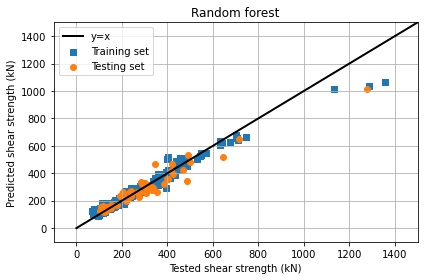

In [9]:
# plotting the scatter for the training and testing sets
import matplotlib.pyplot as plt

xx = np.linspace(0, 1500, 100)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested shear strength (kN)')
plt.ylabel('Predicted shear strength (kN)')
plt.xlim([-100, 1500])
plt.ylim([-100, 1500])
plt.title('Random forest')

plt.tight_layout()

# Building the ensemble learnning model -- AdaBoost

In [10]:
# building the ensemble learnning model
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

regr_2 = AdaBoostRegressor (tree.DecisionTreeRegressor(max_depth=8, min_samples_split=3, min_samples_leaf=2,
                                                       max_leaf_nodes=15, criterion='mse'),
                            n_estimators=400, learning_rate=0.1, random_state=0)


scores = cross_val_score (regr_2, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 56.735682670859205


In [11]:
# training the model
regr_2.fit(X_train, y_train)

# predicting the results
Z1 = regr_2.predict(X_train)
Z2 = regr_2.predict(X_test)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))

Training R2: 0.9703815581955549 RMSE: 30.594220425241428 MAE: 25.889048581397283 MAPE: 0.12377720380548374
Testing R2: 0.919498029661769 RMSE: 53.27463219073729 MAE: 36.65901107186589 MAPE: 0.13165792508035404


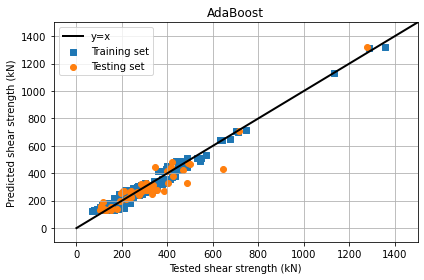

In [12]:
# plotting the scatter for the training and testing sets
import matplotlib.pyplot as plt

xx = np.linspace(0, 1500, 100)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested shear strength (kN)')
plt.ylabel('Predicted shear strength (kN)')
plt.xlim([-100, 1500])
plt.ylim([-100, 1500])
plt.title('AdaBoost')

plt.tight_layout()

# Building the ensemble learnning model -- GBRT

In [13]:
# building the ensemble learnning model
from sklearn.ensemble import GradientBoostingRegressor

regr_3 = GradientBoostingRegressor(n_estimators=500, learning_rate=0.02, max_depth=8, min_samples_leaf=2,
                                   min_samples_split=2, random_state=0, loss='ls')

scores = cross_val_score (regr_3, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 51.75913962955519


In [14]:
# training the model
regr_3.fit(X_train, y_train)

# predicting the results
Z1 = regr_3.predict(X_train)
Z2 = regr_3.predict(X_test)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))

Training R2: 0.9996557887540983 RMSE: 3.298153128971091 MAE: 2.2118859434300977 MAPE: 0.008527108487840638
Testing R2: 0.9105458642244417 RMSE: 56.158748001423746 MAE: 36.29399078672401 MAPE: 0.1246970476057196


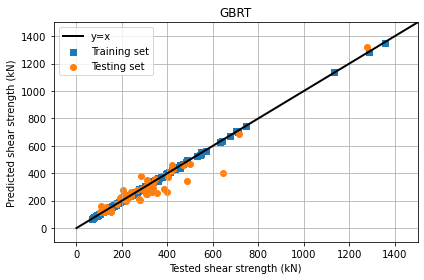

In [15]:
# plotting the scatter for the training and testing sets
import matplotlib.pyplot as plt

xx = np.linspace(0, 1500, 100)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested shear strength (kN)')
plt.ylabel('Predicted shear strength (kN)')
plt.xlim([-100, 1500])
plt.ylim([-100, 1500])
plt.title('GBRT')

plt.tight_layout()

# Building the ensemble learnning model -- XGBoost

In [16]:
# building the ensemble learnning model
import xgboost as xgb

regr_4 = xgb.XGBRegressor (max_depth=8, learning_rate=0.02, n_estimators=600, colsample_bytree=1, 
                           subsample=0.69, gamma=0, random_state=0)

scores = cross_val_score (regr_4, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print('10-fold mean RMSE:', np.mean(np.sqrt( -scores)))

10-fold mean RMSE: 47.849882037585175


In [17]:
# training the model
regr_4.fit(X_train, y_train)

# predicting the results
Z1 = regr_4.predict(X_train)
Z2 = regr_4.predict(X_test)

print("Training R2:", r2_score(y_train, Z1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z1)),
      "MAE:", mean_absolute_error(y_train, Z1), "MAPE:", MAPE(y_train, Z1))
print("Testing R2:", r2_score(y_test, Z2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z2)),
      "MAE:", mean_absolute_error(y_test, Z2), "MAPE:", MAPE(y_test, Z2))

Training R2: 0.9997204999488575 RMSE: 2.9720029331811113 MAE: 1.9672978695636498 MAPE: 0.0074163171546256824
Testing R2: 0.9281211470029462 RMSE: 50.34052889438827 MAE: 31.808108415083453 MAPE: 0.10445019056193061


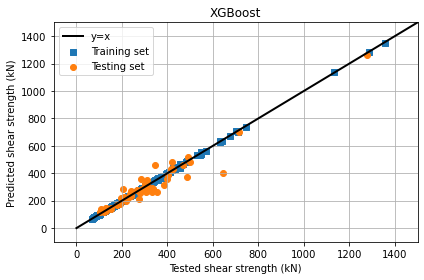

In [18]:
# plotting the scatter for the training and testing sets
import matplotlib.pyplot as plt

xx = np.linspace(0, 1500, 100)
yy = xx

plt.figure()
plt.plot(xx, yy, c='k', linewidth=2)
plt.scatter(y_train, Z1, marker='s')
plt.scatter(y_test, Z2, marker='o')

plt.grid()
plt.legend(['y=x', 'Training set', 'Testing set'], loc = 'upper left')
plt.tick_params (axis = 'both', which = 'major')
plt.axis('tight')
plt.xlabel('Tested shear strength (kN)')
plt.ylabel('Predicted shear strength (kN)')
plt.xlim([-100, 1500])
plt.ylim([-100, 1500])
plt.title('XGBoost')

plt.tight_layout()

# Comparing ensemble model with empirical mechancal models

In [19]:
# impoting the empirical model results database
from openpyxl import load_workbook
em = pd.read_excel('em_data.xlsx', engine='openpyxl')

em.head()

,试件编号,fc'/Mpa,b/mm,h/mm,a/mm,h0/mm,l0/mm,d/mm,a/d,l0/h,...,r/%,Vtest/kN,VGB,VACI,VCSA,VEC2,Vtest/VGB,Vtest/VACI,Vtest/VCSA,Vtest/VEC2
0,0A0-44,20.5,102.0,356,305,305.0,813,305.0,1.0,2.28,...,1.94,139.5,64.46,89.37,117.23,109.44,2.164,1.561,1.19,1.275
1,0A0-48,20.9,102.0,356,305,305.0,813,305.0,1.0,2.28,...,1.94,136.1,65.15,91.12,119.39,111.58,2.089,1.494,1.14,1.220
2,1A1-10,18.7,102.0,356,305,305.0,813,305.0,1.0,2.28,...,1.94,161.2,78.76,101.91,108.19,99.83,2.047,1.582,1.49,1.615
3,1A3-11,18.0,102.0,356,305,305.0,813,305.0,1.0,2.28,...,1.94,148.3,91.39,98.09,105.18,96.10,1.623,1.512,1.41,1.543
4,1A4-12,16.1,102.0,356,305,305.0,813,305.0,1.0,2.28,...,1.94,141.2,101.44,87.74,95.41,85.95,1.392,1.609,1.48,1.643


 mean : 1.4342878228782288  std : 0.3881534039517323  COV : 0.2706244853789619


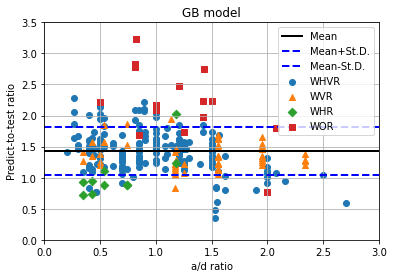

In [20]:
# Results by GB
ratio_GB=em['Vtest/VGB']
mean = np.mean(ratio_GB)
std = np.std(ratio_GB, ddof=1)

print(' mean :', mean, ' std :', std, ' COV :', std/mean)

# Identifying deep beams with different web reinforcements
rv0 = em.loc[em['rv/%'] == 0]         # lines with rho_h==0
rv = em.loc[em['rv/%'] != 0]          # lines with rho_v!=0
rv0rh0 = rv0.loc[ rv0['rh/%'] == 0]   # WHO
rv0rh = rv0.loc[ rv0['rh/%'] != 0]    # WHR
rvrh0 = rv.loc[rv['rh/%']==0]         # WVR
rvrh  =  rv.loc[rv['rh/%']!=0]        # WHVR

rh = rvrh['Vtest/VGB']
rh1 = rvrh['a/d']

r = rvrh0['Vtest/VGB']
r1 = rvrh0['a/d']

h = rv0rh['Vtest/VGB']
h1 = rv0rh['a/d']

OO = rv0rh0['Vtest/VGB']
OO1 = rv0rh0['a/d']

xx = np.linspace(0, 3, 3)
yy = mean*np.ones(3)
yy1 = (mean+std)*np.ones(3)
yy2 = (mean-std)*np.ones(3)

plt.figure()

plt.scatter(rh1, rh, marker='o')
plt.scatter(r1, r, marker='^')
plt.scatter(h1, h, marker='D')
plt.scatter(OO1,OO, marker='s')

plt.plot(xx, yy, c='k', linewidth=2)
plt.plot(xx, yy1, c='b', ls='--', linewidth=2)
plt.plot(xx, yy2, c='b', ls='--', linewidth=2)

plt.xlabel('a/d ratio')
plt.ylabel('Predict-to-test ratio')
plt.xlim([0, 3])
plt.ylim([0, 3.5])
plt.legend(['Mean','Mean+St.D.','Mean-St.D.','WHVR','WVR','WHR','WOR'])
plt.title('GB model')
plt.grid()


 mean : 1.5675498154981546  std : 0.6948786973211271  COV : 0.4432897062989352


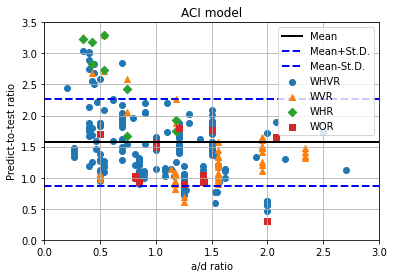

In [21]:
# Results by ACI
ratio_ACI=em['Vtest/VACI']
mean = np.mean(ratio_ACI)
std = np.std(ratio_ACI, ddof=1)

print(' mean :', mean, ' std :', std, ' COV :', std/mean)

# Identifying deep beams with different web reinforcements
rv0 = em.loc[em['rv/%'] == 0]         # lines with rho_h==0
rv = em.loc[em['rv/%'] != 0]          # lines with rho_v!=0
rv0rh0 = rv0.loc[ rv0['rh/%'] == 0]   # WHO
rv0rh = rv0.loc[ rv0['rh/%'] != 0]    # WHR
rvrh0 = rv.loc[rv['rh/%']==0]         # WVR
rvrh  =  rv.loc[rv['rh/%']!=0]        # WHVR

rh = rvrh['Vtest/VACI']
rh1 = rvrh['a/d']

r = rvrh0['Vtest/VACI']
r1 = rvrh0['a/d']

h = rv0rh['Vtest/VACI']
h1 = rv0rh['a/d']

OO = rv0rh0['Vtest/VACI']
OO1 = rv0rh0['a/d']

xx = np.linspace(0, 3, 3)
yy = mean*np.ones(3)
yy1 = (mean+std)*np.ones(3)
yy2 = (mean-std)*np.ones(3)

plt.figure()

plt.scatter(rh1, rh, marker='o')
plt.scatter(r1, r, marker='^')
plt.scatter(h1, h, marker='D')
plt.scatter(OO1,OO, marker='s')

plt.plot(xx, yy, c='k', linewidth=2)
plt.plot(xx, yy1, c='b', ls='--', linewidth=2)
plt.plot(xx, yy2, c='b', ls='--', linewidth=2)

plt.xlabel('a/d ratio')
plt.ylabel('Predict-to-test ratio')
plt.xlim([0, 3])
plt.ylim([0, 3.5])
plt.legend(['Mean','Mean+St.D.','Mean-St.D.','WHVR','WVR','WHR','WOR'])
plt.title('ACI model')
plt.grid()


 mean : 1.5586900369003691  std : 0.5576711096425909  COV : 0.357781917148571


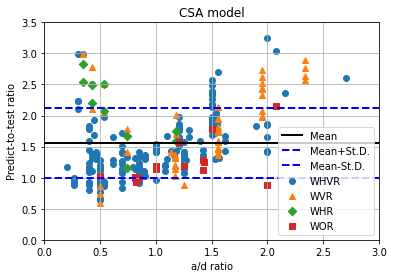

In [22]:
# Results by CSA
ratio_CSA=em['Vtest/VCSA']
mean = np.mean(ratio_CSA)
std = np.std(ratio_CSA, ddof=1)

print(' mean :', mean, ' std :', std, ' COV :', std/mean)

# Identifying deep beams with different web reinforcements
rv0 = em.loc[em['rv/%'] == 0]         # lines with rho_h==0
rv = em.loc[em['rv/%'] != 0]          # lines with rho_v!=0
rv0rh0 = rv0.loc[ rv0['rh/%'] == 0]   # WHO
rv0rh = rv0.loc[ rv0['rh/%'] != 0]    # WHR
rvrh0 = rv.loc[rv['rh/%']==0]         # WVR
rvrh  =  rv.loc[rv['rh/%']!=0]        # WHVR

rh = rvrh['Vtest/VCSA']
rh1 = rvrh['a/d']

r = rvrh0['Vtest/VCSA']
r1 = rvrh0['a/d']

h = rv0rh['Vtest/VCSA']
h1 = rv0rh['a/d']

OO = rv0rh0['Vtest/VCSA']
OO1 = rv0rh0['a/d']

xx = np.linspace(0, 3, 3)
yy = mean*np.ones(3)
yy1 = (mean+std)*np.ones(3)
yy2 = (mean-std)*np.ones(3)

plt.figure()

plt.scatter(rh1, rh, marker='o')
plt.scatter(r1, r, marker='^')
plt.scatter(h1, h, marker='D')
plt.scatter(OO1,OO, marker='s')

plt.plot(xx, yy, c='k', linewidth=2)
plt.plot(xx, yy1, c='b', ls='--', linewidth=2)
plt.plot(xx, yy2, c='b', ls='--', linewidth=2)

plt.xlabel('a/d ratio')
plt.ylabel('Predict-to-test ratio')
plt.xlim([0, 3])
plt.ylim([0, 3.5])
plt.legend(['Mean','Mean+St.D.','Mean-St.D.','WHVR','WVR','WHR','WOR'])
plt.title('CSA model')
plt.grid()


 mean : 1.418922509225092  std : 0.540861971070917  COV : 0.38117794844645525


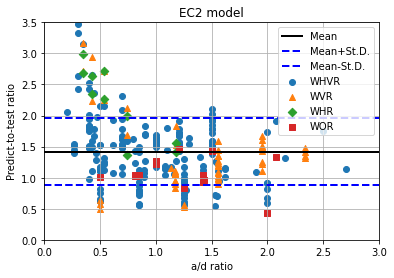

In [23]:
# Results by EC2
ratio_EC2=em['Vtest/VEC2']
mean = np.mean(ratio_EC2)
std = np.std(ratio_EC2, ddof=1)

print(' mean :', mean, ' std :', std, ' COV :', std/mean)

# Identifying deep beams with different web reinforcements
rv0 = em.loc[em['rv/%'] == 0]         # lines with rho_h==0
rv = em.loc[em['rv/%'] != 0]          # lines with rho_v!=0
rv0rh0 = rv0.loc[ rv0['rh/%'] == 0]   # WHO
rv0rh = rv0.loc[ rv0['rh/%'] != 0]    # WHR
rvrh0 = rv.loc[rv['rh/%']==0]         # WVR
rvrh  =  rv.loc[rv['rh/%']!=0]        # WHVR

rh = rvrh['Vtest/VEC2']
rh1 = rvrh['a/d']

r = rvrh0['Vtest/VEC2']
r1 = rvrh0['a/d']

h = rv0rh['Vtest/VEC2']
h1 = rv0rh['a/d']

OO = rv0rh0['Vtest/VEC2']
OO1 = rv0rh0['a/d']

xx = np.linspace(0, 3, 3)
yy = mean*np.ones(3)
yy1 = (mean+std)*np.ones(3)
yy2 = (mean-std)*np.ones(3)

plt.figure()

plt.scatter(rh1, rh, marker='o')
plt.scatter(r1, r, marker='^')
plt.scatter(h1, h, marker='D')
plt.scatter(OO1,OO, marker='s')

plt.plot(xx, yy, c='k', linewidth=2)
plt.plot(xx, yy1, c='b', ls='--', linewidth=2)
plt.plot(xx, yy2, c='b', ls='--', linewidth=2)

plt.xlabel('a/d ratio')
plt.ylabel('Predict-to-test ratio')
plt.xlim([0, 3])
plt.ylim([0, 3.5])
plt.legend(['Mean','Mean+St.D.','Mean-St.D.','WHVR','WVR','WHR','WOR'])
plt.title('EC2 model')
plt.grid()


 mean : 1.0040105789835214  std : 0.06997854160132344  COV : 0.06969900822376891


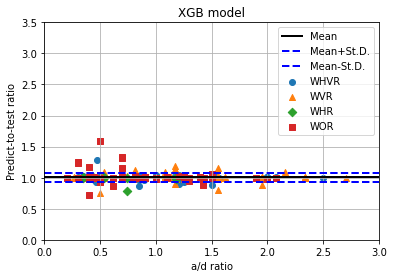

In [24]:
# Results by XGBoost
from openpyxl import load_workbook
em_xgb = pd.read_excel('em_xgb.xlsx', engine='openpyxl')

X_new = em_xgb.loc[:, em_xgb.columns != 'Vtest/kN']
X_new = scaler.transform(X_new)
y_new = em_xgb['Vtest/kN']

xgb_res = y_new / regr_4.predict(X_new)
em_xgb['XGB'] = xgb_res

ratio_XGB = xgb_res
mean = np.mean(ratio_XGB)
std = np.std(ratio_XGB, ddof=1)

print(' mean :', mean, ' std :', std, ' COV :', std/mean)

# Identifying deep beams with different web reinforcements
rv0 = em_xgb.loc[em_xgb['rv/%'] == 0]         # lines with rho_h==0
rv = em_xgb.loc[em_xgb['rv/%'] != 0]          # lines with rho_v!=0
rv0rh0 = rv0.loc[ rv0['rh/%'] == 0]   # WHO
rv0rh = rv0.loc[ rv0['rh/%'] != 0]    # WHR
rvrh0 = rv.loc[rv['rh/%']==0]         # WVR
rvrh  =  rv.loc[rv['rh/%']!=0]        # WHVR

rh = rvrh['XGB']
rh1 = rvrh['a/d']

r = rvrh0['XGB']
r1 = rvrh0['a/d']

h = rv0rh['XGB']
h1 = rv0rh['a/d']

OO = rv0rh0['XGB']
OO1 = rv0rh0['a/d']

xx = np.linspace(0, 3, 3)
yy = mean*np.ones(3)
yy1 = (mean+std)*np.ones(3)
yy2 = (mean-std)*np.ones(3)

plt.figure()

plt.scatter(rh1, rh, marker='o')
plt.scatter(r1, r, marker='^')
plt.scatter(h1, h, marker='D')
plt.scatter(OO1,OO, marker='s')

plt.plot(xx, yy, c='k', linewidth=2)
plt.plot(xx, yy1, c='b', ls='--', linewidth=2)
plt.plot(xx, yy2, c='b', ls='--', linewidth=2)

plt.xlabel('a/d ratio')
plt.ylabel('Predict-to-test ratio')
plt.xlim([0, 3])
plt.ylim([0, 3.5])
plt.legend(['Mean','Mean+St.D.','Mean-St.D.','WHVR','WVR','WHR','WOR'])
plt.title('XGB model')
plt.grid()

# Feature importance analysis with the XGboost model

[0.34275573 0.06170886 0.02843825 0.12230585 0.02407629 0.04751112
 0.05935682 0.01937222 0.08552857 0.01394116 0.0429781  0.06235033
 0.00444749 0.03476736 0.01099042 0.03947143]


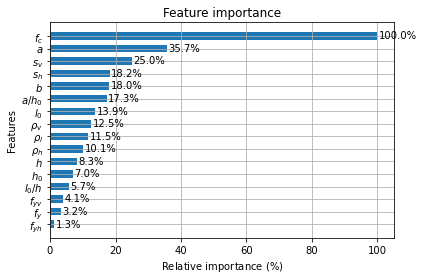

In [25]:
# slecting the XGBoost model
model = regr_4

# plot the feature imprtance
feature_names = [r'$f_c$', r'$b$', r'$h$', r'$a$', r'$h_0$', r'$l_0$', r'$a/h_0$',
                 r'$l_0/h$', r'$s_v$', r'$f_{yv}$', r'$\rho_v$', r'$s_h$', r'$f_{yh}$',
                 r'$\rho_h$', r'$f_y$', r'$\rho_l$']

model.importance_type = 'weight'
feature_importance = model.feature_importances_

print(feature_importance)

plt.figure()

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh (pos, feature_importance[sorted_idx], 0.6, align='center',)
plt.yticks(pos, np.array(feature_names)[sorted_idx], style='italic')
plt.yticks(rotation=360)

for x, y in enumerate(feature_importance[sorted_idx]):
	plt.text(y + 0.5, x + 0.3, '%s' % '{:.1%}'.format(y/100))

plt.xlabel('Relative importance ($\%$)')
plt.ylabel('Features')
plt.title('Feature importance')
plt.grid()
plt.tight_layout()

# Partial dependence plots with the XGBoost model

In [26]:
from pdpbox import pdp

x = ['fc','b','h','a','h0','l0','a/h0','l0/h','sv','fyv','rho_v','sh','fyh','rho_h','fy','rho_y']

pdp_goals = pdp.pdp_isolate (model = model, dataset = dataset, model_features = x, feature = 'b')
pdp.pdp_plot(pdp_goals, 'b')
plt.show()

ModuleNotFoundError: No module named 'pdpbox'